In [ ]:
include("../load.jl")

In [ ]:
using Plots
using LaTeXStrings
using JuMP

In [51]:
# Creating the GlobalModel
m = JuMP.Model(with_optimizer(CPLEX_SILENT))
# @variable(m, -20 <= x[1:2] <= 20)
# set_lower_bound(x[2], 0)
# set_upper_bound(x[2], 10)
@variable(m, 1 <= x[1:2] <= 5)
@variable(m, y)
gm = GlobalModel(model = m)
# add_nonlinear_constraint(gm, :(x -> x[1]^2 + x[2]^2), dependent_var = y)
# add_nonlinear_constraint(gm, :(x -> log(x[1]^2 + x[2]^2)), dependent_var = y)
# add_nonlinear_constraint(gm, :(x -> exp(- 1/6*(x[1]^2) - 1/10*(x[2]^2))), dependent_var = y)
# add_nonlinear_constraint(gm, :(x -> x[1] + x[2]), dependent_var = y)
# add_nonlinear_constraint(gm, :(x -> x[1]^4*x[2]^2 + x[1]^2*x[2]^4 - 3*x[1]^2*x[2]^2 + 1), dependent_var = y)
add_nonlinear_constraint(gm, :(x -> max(0, x[1] - 2 - 0.1*x[1]*x[2]^2, x[2] - 2)), dependent_var = y)
bbr = gm.bbls[end]
set_param(bbr, :n_samples, 500)
uniform_sample_and_eval!(gm, lh_iterations=20)
classify_curvature(bbr)

┌ Warning: Missing gradient information was updated.
└ @ Main.OptimalConstraintTree C:\Users\berko\Code\OptimalConstraintTree\src\root_finding.jl:87


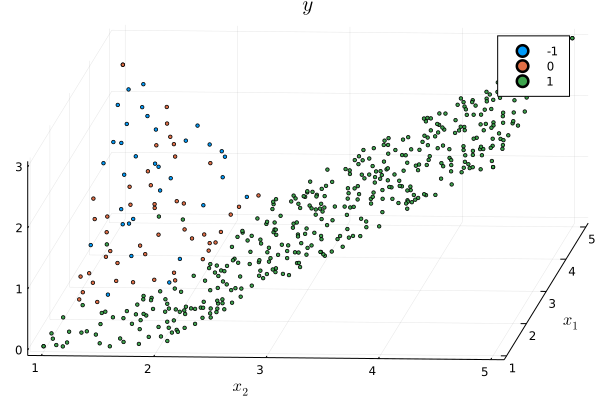

In [52]:
# Curvature plot
bbr = gm.bbls[1]
plt3d = Plots.plot()
for val in [-1, 0, 1]
    idxs = findall(i -> i == val, bbr.curvatures)
    Plots.scatter!(bbr.X[idxs,"x[2]"], bbr.X[idxs,"x[1]"], bbr.Y[idxs], markersize = 2, label = val, camera = (10,50))
end
xlabel!(L"$x_2$"); ylabel!(L"$x_1$"); title!(L"$y$")
display(plt3d)

In [63]:
# We can train trees over the curvatures
lnr = base_classifier()
kwargs = Dict()
nl = learn_from_data!(bbr.X, bbr.curvatures .> 0, lnr; fit_classifier_kwargs(; kwargs...)...)

Training trees...                  100%|████████████████| Time: 0:00:00


Fitted OptimalTreeClassifier:
  1) Split: -0.002067 * x[1] + 0.0299 * x[2] < 0.05661
    2) Split: 0.09695 * x[1] - 0.05525 * x[2] < 0.1613
      3) Predict: true (100.00%), [0,46], 46 points, error 0
      4) Split: -5.02 * x[1] + 12.79 * x[2] < 8.267
        5) Predict: false (96.47%), [82,3], 85 points, error 0.007126
        6) Predict: true (100.00%), [0,5], 5 points, error 0
    7) Predict: true (100.00%), [0,364], 364 points, error 0

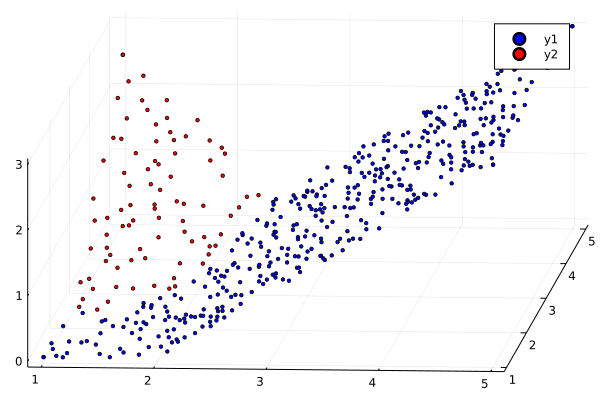

In [64]:
# Plotting convexity
preds = IAI.predict(nl, bbr.X);
one_preds = findall(x -> x == 1, preds)
zero_preds = findall(x -> x == 0, preds)
Plots.scatter(bbr.X[one_preds,"x[2]"], bbr.X[one_preds,"x[1]"], bbr.Y[one_preds], 
            markersize = 2, seriescolor=:blue, camera = (10,50))
Plots.scatter!(bbr.X[zero_preds,"x[2]"], bbr.X[zero_preds,"x[1]"], bbr.Y[zero_preds], 
            markersize = 2, seriescolor=:red, camera = (10,50))

In [10]:
# How about univariate example? Try the one from Woody's fitting paper. 
m = JuMP.Model()
@variable(m, -5 <= x <= 10)
@variable(m, y)
gm = GlobalModel(model = m)
# add_nonlinear_constraint(gm, :(x -> max.(-6*x .-6,0.5x,0.2x.^5+0.5x)), dependent_var = y)
add_nonlinear_constraint(gm, :(x -> x^1.2*sin(x)), dependent_var = y)
uniform_sample_and_eval!(gm)
classify_curvature(gm.bbls[1])

┌ Warning: Missing gradient information was updated.
└ @ Main.OptimalConstraintTree C:\Users\berko\Code\OptimalConstraintTree\src\root_finding.jl:87


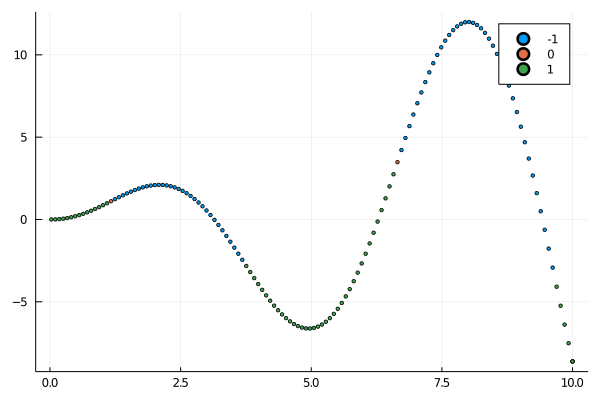

In [11]:
bbr = gm.bbls[1]
plt2d = Plots.plot()
for val in [-1, 0, 1]
    idxs = findall(i -> i == val, bbr.curvatures)
    Plots.scatter!(bbr.X[idxs,"x"], bbr.Y[idxs], markersize = 2, label = val)
end
display(plt2d)